# Random and probabilistic model ( rpm )

In [1]:
# Import auxiliary libraries for demonstration

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.rcParams[ "figure.figsize" ] = [ 5, 4 ]

plt.rcParams[ "figure.dpi" ] = 80
plt.rcParams[ "font.family" ] = "Times New Roman"
plt.rcParams[ "font.size" ] = '14'

## Metropolis–Hastings algorithm

The metropolis-Hastings algorithm is a typical algorithm that generates the samples for an arbitrary density function (i.e., target density function). It uses the transition kernel (i.e., proposal density) to generate the next sample candidate. The candidate is accepted with the acceptance ratio calculated by the target density function.

### Metropolis–Hastings sampler

Class `MetropolisHastingsSampler` implements the Metropolis-Hastings sampler.

Based on the algorithm, three input parameters, namely `initialVal`, `targetPdf`, `proposalCSampler` are required to create a Metropolis-Hastings sampler. 

`initialVal` is the first observed data point that is used to start the sampling procedure. 

`targetPdf` is a target density function that returns the probability for a given value. It should be noted that the `targetPdf` function can be proportional to the target density function up to a multiplicative constant. 

`proposalCSampler` is a sampler that can return a sample for a given observation. For example, for a given observation $x_t$, the sampler can be $x_{t+1} \sim \mathcal{N}(x_t, 1)$ and it can return a sample based on the current observation $x_t$.

The following examples show the application of the Metropolis-Hastings sampler for exponential-like and lognormal-like target distribution.

#### Class initialization help

In [2]:
from ffpack.rpm import MetropolisHastingsSampler
help( MetropolisHastingsSampler.__init__ )

Help on function __init__ in module ffpack.rpm.metropolisHastings:

__init__(self, initialVal=None, targetPdf=None, proposalCSampler=None)
    Initialize the Metropolis-Hastings sampler
    
    Parameters
    ----------
    initialVal: scalar or array_like of scalar
        Initial observed data point.
    targetPdf: function
        Target probability density function or target distribution function.
        targetPdf takes one input parameter and return the corresponding 
        probability.
    proposalCSampler: function
        Proposal conditional sampler. proposalCSampler is a sampler that will 
        return a sample for the given observed data point. A usual choice is to 
        let proposalCSampler be a Gaussian/normal distribution centered at the 
        observed data point.
    
    Raises
    ------
    ValueError
        If any input parameter is None.
        If targetPdf returns negative value.
    
    Examples
    --------
    >>> from ffpack.rpm import Metropolis

#### Example with exponential-like distribution

In [3]:
# Set random seed for repeatable results
from ffpack.config import globalConfig
globalConfig.setSeed( 0 )

mhsInitialVal = 1.0

# def mhsTargetPdf( x ):
#     return 0 if x < 0 else np.exp( -x )
mhsTargetPdf = lambda x : 0 if x < 0 else np.exp( -x )

# def mhsProposalCSampler( x ):
#     return np.random.normal( x, 1 )
mhsProposalCSampler = lambda x : np.random.normal( x, 1 )

In [4]:
mhSampler = MetropolisHastingsSampler( initialVal=mhsInitialVal, 
                                       targetPdf=mhsTargetPdf, 
                                       proposalCSampler=mhsProposalCSampler )

In [5]:
mhsResults = np.zeros( 10000 )
for i in range( 10000 ):
    mhsResults[ i ] = mhSampler.getSample()

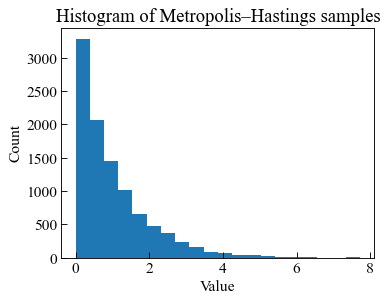

In [6]:
fig, ax = plt.subplots()

ax.hist( np.array( mhsResults ), bins=20 )

ax.tick_params(axis='x', direction="in", length=5)
ax.tick_params(axis='y', direction="in", length=5)
ax.set_ylabel( "Count" )
ax.set_xlabel( "Value" )
ax.set_title( "Histogram of Metropolis–Hastings samples" )

plt.tight_layout()
plt.show()

#### Example with lognormal-like distribution

In [7]:
# Set random seed for repeatable results
from ffpack.config import globalConfig
globalConfig.setSeed( 0 )

mhsInitialVal = 1.0

def mhsTargetPdf( x ):
    return 0 if x < 0 else 1 / x * np.exp( -1 * np.power( np.log( x ), 2 ) )

def mhsProposalCSampler( x ):
    return np.random.normal( x, 1 )

In [8]:
mhSampler = MetropolisHastingsSampler( initialVal=mhsInitialVal, 
                                       targetPdf=mhsTargetPdf, 
                                       proposalCSampler=mhsProposalCSampler )

In [9]:
mhsResults = np.zeros( 10000 )
for i in range( 10000 ):
    mhsResults[ i ] = mhSampler.getSample()

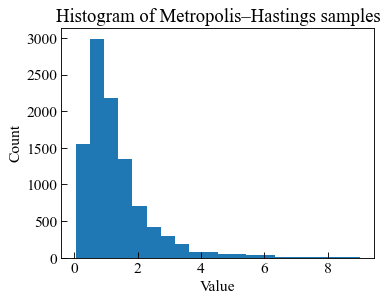

In [10]:
fig, ax = plt.subplots()

ax.hist( np.array( mhsResults ), bins=20 )

ax.tick_params(axis='x', direction="in", length=5)
ax.tick_params(axis='y', direction="in", length=5)
ax.set_ylabel( "Count" )
ax.set_xlabel( "Value" )
ax.set_title( "Histogram of Metropolis–Hastings samples" )

plt.tight_layout()
plt.show()

## Nataf algorithm

### Nataf transformation

Nataf transformation is a isoprobabilistic transformation to create the joint distribution based on the marginal distributions and linear correlation coefficients. Gaussian copula is assumed in the Nataf transformation for the joint distribution.

Here, we give a brief introduction to the Nataf transformation. The details can be found in the references. For the random variables $\mathbf{X} = (X_1, X_2, \dots, X_n)$, we know the marginal distributions $f_{X_i}$ for each random variable and the correlation coefficients $\rho_{ij}$ for any two random variables $X_i$ and $X_j$. Nataf transformation represents the joint distribution of the random variables $\mathbf{X}$ with the Gaussian copula. There are two steps in Nataf transformaton:

1. Transfrom correlated random variables $\mathbf{X}$ into correlated standard normal variables $\mathbf{Z}$.
2. Transfrom correlated standard normal variables $\mathbf{Z}$ into independent standard normal variables $\mathbf{U}$.

To transform a random variable $X_i$ to standard normal variables $Z_i$, the following transformation can be performed for each random variable,

$$
z_i = \mathbf{\Phi}^{-1} ( F_{X_i}(x_i) )
$$

Since the random variables $\mathbf{X}$ are correlated with the correlation coefficients $\rho_{ij}$ for $X_i$ and $X_j$, the key for the step 1 in Nataf transformation is to solve the $\rho_{0,ij}$ for $\mathbf{Z}$. The $\rho_{0,ij}$ for $Z_i$ and $Z_j$ can be expressed with the implicit function,

$$
\rho_{ij} = \int_R \int_R \left( \frac{F^{-1}_{X_i} (\Phi(z_i))-\mu_i}{\sigma_i} \right)\left( \frac{F^{-1}_{X_j} (\Phi(z_j))-\mu_j}{\sigma_j} \right) \phi(z_i, z_j; \rho_{0,ij}) \text{d}z_i \text{d}z_j
$$

where $\phi( x, y; \rho) $ is the standard bivariate normal distribution with correlation coefficient $\rho$.

$$
\phi( x, y; \rho) = \frac{1}{2 \pi \sqrt{ 1 - \rho^2 }} \exp{\left( -\frac{x^2 - 2 \rho x y + y^2}{2 (1 - \rho^2 ) } \right) }
$$

After solving the aforementioned equation, we know the correlation coefficient $\rho_{0,ij}$ for $Z_i$ and $Z_j$. The correlation matrix for $\mathbf{Z}$ is denoted by $\mathbf{R}_0$. Then, Cholesky decomposition of correlation matrix $\mathbf{R}_0$ is performed,

$$
\mathbf{R}_0 = \mathbf{L}_0 \mathbf{L}_0^T
$$

The step 2 in Nataf transformation can be performed,

$$
\mathbf{U} = \mathbf{L}_0^{-1} \mathbf{Z}
$$

Then, we map the correlated random variable $\mathbf{X}$ (data point in X space) to independent standard normal variables $\mathbf{U}$ (data point in U space) now.

Reference: 

* Lemaire, M., 2013. Structural reliability. John Wiley & Sons.
* Bourinet, J.M., 2018. Reliability analysis and optimal design under uncertainty-Focus on adaptive surrogate-based approaches (Doctoral dissertation, Université Clermont Auvergne).
* Wang, C., 2021. Structural reliability and time-dependent reliability. Cham, Switzerland: Springer.

#### Class initialization help

In [11]:
from ffpack.rpm import NatafTransformation
help( NatafTransformation.__init__ )

Help on function __init__ in module ffpack.rpm.nataf:

__init__(self, distObjs, corrMat, quadDeg=99, quadRange=8)
    Initialize the Nataf distribution.
    
    Parameters
    ----------
    distObjs: array_like of distributions
        Marginal distribution objects. It should be the freezed distribution 
        objects with pdf, cdf, ppf. We recommend to use scipy.stats functions.
    corrMat: 2d matrix
        Correlation matrix of the marginal distributions.
    quadDeg: int
        Quadrature degree.
    quadRange: scalar
        Quadrature range. The integral will be performed in the range
        [ -quadRange, quadRange ].
    
    Raises
    ------
    ValueError
        If distObjs is empty.
        If dimensions are not match for distObjs and corrMat.
        If corrMat is not 2d matrix.
        If corrMat is not positive definite.
        If corrMat is not symmetric.
        If corrMat diagonal is not 1.
    
    Examples
    --------
    >>> from ffpack.rpm import NatafTra

#### Example with normal distribution

In [12]:
# Define a standard bivariate normal distribution with correlation coefficient for comparison
def standardBivariateNormalDistributionWithCorrelationCoefficient( x, y, rho ):
    return 1 / ( 2 * np.pi * np.sqrt( 1 - rho**2) ) * \
           np.exp( -1 / ( 2 * ( 1 - rho**2 ) ) * 
           ( x**2 - 2 * rho * x * y + y**2 ) )

In [13]:
# We create the Nataf transformation with 2 normal distributions
natafDistObjs = [ stats.norm(), stats.norm() ]
natafCorrMat = [ [ 1.0, 0.5 ], [ 0.5, 1.0 ] ]

natafNormDist = NatafTransformation( distObjs=natafDistObjs, corrMat=natafCorrMat )

In [14]:
# Transformation from U space to X space
natafU = [ 1.0, 1.0 ]
natafX, natafJ = natafNormDist.getX( natafU )
print( "Data point coordinate in U space: " )
print( natafU )
print()
print( "Data point coordinate in X space: " )
print( natafX )
print()
print( "Jacobian matrix for transformation: " )
print( natafJ )

Data point coordinate in U space: 
[1.0, 1.0]

Data point coordinate in X space: 
[1.        1.3660254]

Jacobian matrix for transformation: 
[[ 1.          0.        ]
 [-0.57735027  1.15470054]]


In [15]:
# Transformation from X space to U space
natafX = [ 1.0, 1.0 ]
natafU, natafJ = natafNormDist.getU( natafX )
print( "Data point coordinate in X space: " )
print( natafX )
print()
print( "Data point coordinate in U space: " )
print( natafU )
print()
print( "Jacobian matrix for transformation: " )
print( natafJ )

Data point coordinate in X space: 
[1.0, 1.0]

Data point coordinate in U space: 
[1.         0.57735027]

Jacobian matrix for transformation: 
[[1.        0.       ]
 [0.5       0.8660254]]


In [16]:
# Joint pdf for X
natafX = [ 1.0, 0.5 ]
natafPdfX = natafNormDist.pdf( natafX )
print( "pdf from Nataf transformation: " )
print( natafPdfX )
print()
print( "pdf from standard bivariate normal distribution with correlation coefficient:" )
print( standardBivariateNormalDistributionWithCorrelationCoefficient( 1.0, 0.5, 0.5 ) ) 

pdf from Nataf transformation: 
0.11146595955294503

pdf from standard bivariate normal distribution with correlation coefficient:
0.11146595955293902


In [17]:
# Joint cdf for X
natafX = [ 1.0, 0.5 ]
natafCdfX = natafNormDist.cdf( natafX )
print( "cdf from Nataf transformation: " )
print( natafCdfX )

cdf from Nataf transformation: 
0.630283927552582


#### Example with exponential distribution

In [18]:
# We create the Nataf transformation with 2 normal distributions
natafDistObjs = [ stats.expon(), stats.expon() ]
natafCorrMat = [ [ 1.0, 0.2 ], [ 0.2, 1.0 ] ]

natafExponDist = NatafTransformation( distObjs=natafDistObjs, corrMat=natafCorrMat )

In [19]:
# Transformation from U space to X space
natafU = [ 1.0, 1.0 ]
natafX, natafJ = natafExponDist.getX( natafU )
print( "Data point coordinate in U space: " )
print( natafU )
print()
print( "Data point coordinate in X space: " )
print( natafX )
print()
print( "Jacobian matrix for transformation: " )
print( natafJ )

Data point coordinate in U space: 
[1.0, 1.0]

Data point coordinate in X space: 
[1.84102165 2.17177436]

Jacobian matrix for transformation: 
[[ 0.65567954  0.        ]
 [-0.15726467  0.6077046 ]]


In [20]:
# Transformation from X space to U space
natafX = [ 1.0, 1.0 ]
natafU, natafJ = natafExponDist.getU( natafX )
print( "Data point coordinate in X space: " )
print( natafX )
print()
print( "Data point coordinate in U space: " )
print( natafU )
print()
print( "Jacobian matrix for transformation: " )
print( natafJ )

Data point coordinate in X space: 
[1.0, 1.0]

Data point coordinate in U space: 
[0.33747496 0.26610302]

Jacobian matrix for transformation: 
[[1.02440995 0.        ]
 [0.23892819 0.99615715]]


In [21]:
# Joint pdf for X
natafX = [ 1.0, 0.5 ]
natafPdfX = natafExponDist.pdf( natafX )
print( "pdf from Nataf transformation: " )
print( natafPdfX )

pdf from Nataf transformation: 
0.22315052067193208


In [22]:
# Joint cdf for X
natafX = [ 1.0, 0.5 ]
natafCdfX = natafExponDist.cdf( natafX )
print( "cdf from Nataf transformation: " )
print( natafCdfX )

cdf from Nataf transformation: 
0.2824109061173752
